In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

pd.set_option('max_rows', 10)



# Financial Sector - Estimation

All data series were downloaded from the [World Bank Website](http://data.worldbank.org)

* Financial Depth: Domestic credit provided by financial sector (% of GDP) - EXPLANATORY VARIABLE
* Real GDP Per Capita: GDP per capita, PPP (current international $) - RESPONSE VARIABLE
* Inflation Rate Inflation, consumer prices (annual %) - CONTROL VARIABLE
* Merchandise Trade: Merchandise trade (% of GDP) - CONTROL VARIABLE
* Primary completion rate, total (% of relevant age group) - We opted for this as a education proxy - CONTROL VARIABLE


## Load

In [2]:
df = pd.read_excel('Data.xlsx',None)

In [3]:
def sortDf(df,key):
    df.drop(['Country Name','Indicator Code','Indicator Name',], axis=1, inplace=True)
    df = pd.DataFrame(df.set_index('Country Code').stack())
    df.columns = [key]
    return df

In [4]:
dfsList = []
for key in df.keys():
    dfsList.append(sortDf(df[key],key))

In [5]:
df = pd.concat(dfsList,axis=1)
df

FinancDepth  PrimaryRateCompletion         Pop  \
Country Code                                                        
ABW          1960          NaN                    NaN     54208.0   
             1961          NaN                    NaN     55435.0   
             1962          NaN                    NaN     56226.0   
             1963          NaN                    NaN     56697.0   
             1964          NaN                    NaN     57029.0   
...                        ...                    ...         ...   
ZWE          2011          NaN                    NaN  14255592.0   
             2012          NaN              89.225418  14565482.0   
             2013          NaN              90.249062  14898092.0   
             2014          NaN                    NaN  15245855.0   
             2015          NaN                    NaN  15602751.0   

                   InflationRate  GrossCapital  RealGdpPerCapita  MerchanTrade  
Country Code                                                                    
ABW          1960            NaN           NaN               NaN           NaN  
             1961            NaN           NaN               NaN           NaN  
             1962            NaN           NaN               NaN           NaN  
             1963            NaN           NaN               NaN           NaN  
             1964            NaN           NaN               NaN           NaN  
...                          ...           ...               ...           ...  
ZWE          2011       3.277509     22.392920       1523.621784     72.215785  
             2012       3.922235     13.612891       1679.125594     66.833044  
             2013       1.631622     13.033016       1743.210783     57.873718  
             2014      -0.217286     13.236799       1798.059812     51.164230  
             2015      -2.398710     13.239581       1793.586092     48.338968  

[14628 rows x 7 columns]

# Selecting Our Sample

We will try to use a similar time window of 15 years, thus from 2000 to 2015

In [6]:
df = df.swaplevel()

listOfYears = []
for i in range(1999,2016):
    listOfYears.append(str(i))

df.sort_index(inplace=True)
idx = pd.IndexSlice
df = df.loc[idx[listOfYears,:],:]
df

FinancDepth  PrimaryRateCompletion         Pop  \
     Country Code                                                   
1999 ABW             44.554334             101.619118     89004.0   
     AFG                   NaN                    NaN  19038420.0   
     AGO              7.219949                    NaN  14601983.0   
     ALB             50.112177                    NaN   3108778.0   
     AND                   NaN                    NaN     64161.0   
...                        ...                    ...         ...   
2015 WSM             76.109221                    NaN    193228.0   
     YEM                   NaN                    NaN  26832215.0   
     ZAF            180.050114                    NaN  54956920.0   
     ZMB             29.448022                    NaN  16211767.0   
     ZWE                   NaN                    NaN  15602751.0   

                   InflationRate  GrossCapital  RealGdpPerCapita  MerchanTrade  
     Country Code                                                               
1999 ABW                2.280372     27.723498               NaN    196.364238  
     AFG                     NaN           NaN               NaN           NaN  
     AGO              248.195902     28.899574       2972.321938    134.342357  
     ALB                0.389438     22.986393       3684.945153     44.085370  
     AND                     NaN           NaN               NaN           NaN  
...                          ...           ...               ...           ...  
2015 WSM                0.724470           NaN       5922.815359     50.813106  
     YEM                     NaN           NaN               NaN           NaN  
     ZAF                4.588271     19.508398      13165.148024     59.556919  
     ZMB               10.100695           NaN       3852.658974     72.693816  
     ZWE               -2.398710     13.239581       1793.586092     48.338968  

[4469 rows x 7 columns]

Now we have to find countries with complete data

In [7]:
df = df.swaplevel().sort_index()

In [8]:
pd.set_option('max_rows', 500)
~(df.isnull().groupby(level="Country Code").any().any(axis=1))

Country Code
ABW    False
AFG    False
AGO    False
ALB    False
AND    False
ARB    False
ARE    False
ARG    False
ARM    False
ASM    False
ATG    False
AUS    False
AUT    False
AZE    False
BDI    False
BEL    False
BEN    False
BFA    False
BGD    False
BGR    False
BHR    False
BHS    False
BIH    False
BLR    False
BLZ    False
BMU    False
BOL    False
BRA    False
BRB    False
BRN    False
BTN    False
BWA    False
CAF    False
CAN    False
CEB    False
CHE    False
CHI    False
CHL    False
CHN    False
CIV    False
CMR    False
COD    False
COG    False
COL    False
COM    False
CPV    False
CRI    False
CSS    False
CUB    False
CUW    False
CYM    False
CYP    False
CZE    False
DEU    False
DJI    False
DMA    False
DNK    False
DOM    False
DZA    False
EAP    False
EAR    False
EAS    False
ECA    False
ECS    False
ECU    False
EGY    False
EMU    False
ERI    False
ESP    False
EST    False
ETH    False
EUU    False
FCS    False
FIN    False
FJI    False
FRA    False

In [9]:
df.loc["USA"]

,FinancDepth,PrimaryRateCompletion,Pop,InflationRate,GrossCapital,RealGdpPerCapita,MerchanTrade
1999,201.263956,NaN,279040000.0,2.188027,23.317953,34620.928899,18.168982
2000,190.962275,NaN,282162411.0,3.376857,23.568925,36449.855116,19.846980
2001,198.587775,NaN,284968955.0,2.826171,22.051491,37273.618103,17.965653
2002,191.785229,NaN,287625193.0,1.586032,21.576522,38166.037841,17.247375
2003,206.579807,NaN,290107933.0,2.270095,21.659967,39677.198348,17.616881
2004,212.918016,NaN,292805298.0,2.677237,22.526727,41921.809762,19.067770
2005,216.329179,NaN,295516599.0,3.392747,23.222953,44307.920585,20.114886
2006,226.324174,NaN,298379912.0,3.225944,23.333015,46437.067117,21.247602
2007,235.894430,NaN,301231207.0,2.852672,22.351353,48061.537661,21.886185
2008,216.762891,NaN,304093966.0,3.839100,20.786244,48401.427340,23.486835


It appears that Primary Rate completion is not filled for many countries. Thus we will drop it for now.

In [10]:
df.drop('PrimaryRateCompletion',axis=1,inplace=True)

In [11]:
sampleCountries = ~(df.isnull().groupby(level="Country Code").any().any(axis=1))

In [12]:
sampleCountries = sampleCountries[sampleCountries==True].index
len(sampleCountries)

101

We have 101 countries in the sample. Which is more than the original paper with 77. We have our samples.

In [13]:
df = df.loc[list(sampleCountries)]

# Data Manipulations

## Calculate GDP Growth Rate

Since we only have the absolute value of the variable

In [14]:
df['GdpRate'] = df['RealGdpPerCapita'].groupby(level="Country Code").shift(0) / df['RealGdpPerCapita'].groupby(level="Country Code").shift(1)

## Ln() of Inflation

In [15]:
df['LnInflation'] = np.log(df['InflationRate'] /  100)

In [16]:
df.head()

FinancDepth         Pop  InflationRate  GrossCapital  \
Country Code                                                              
AGO          1999     7.219949  14601983.0     248.195902     28.899574   
             2000   -14.755435  15058638.0     324.996872     12.755027   
             2001    -0.319143  15562791.0     152.561022     13.450919   
             2002     5.004125  16109696.0     108.897436     37.296420   
             2003     6.626453  16691395.0      98.223718     38.228106   

                   RealGdpPerCapita  MerchanTrade   GdpRate  LnInflation  
Country Code                                                              
AGO          1999       2972.321938    134.342357       NaN     0.909048  
             2000       3036.559728    120.059565  1.021612     1.178645  
             2001       3131.995858    108.694391  1.031429     0.422394  
             2002       2858.897069     96.724531  0.912804     0.085236  
             2003       2961.964572    105.631501  1.036051    -0.017922

# Estimation

In [17]:
finalSample = df.groupby(level='Country Code').mean()
finalSample.head()

,FinancDepth,Pop,InflationRate,GrossCapital,RealGdpPerCapita,MerchanTrade,GdpRate,LnInflation
Country Code,,,,,,,,
AGO,10.225204,1.940390e+07,65.629633,21.209882,5076.298701,94.360654,1.061294,-1.261715
ALB,58.261895,2.977762e+06,2.463691,33.164009,7593.348105,47.337332,1.073425,-4.065030
ARM,21.674713,3.012460e+06,3.937327,26.849415,5432.326964,54.208403,1.092614,-3.416228
ATG,85.296767,8.438524e+04,1.949115,28.899016,19611.929659,53.736358,1.031085,-4.005236
AUS,131.351110,2.114647e+07,2.794667,26.982632,35904.048442,33.914163,1.037834,-3.633616


In [18]:
# finalSample['LnPop'] = np.log(finalSample['Pop'])
finalSample['LnPop'] = finalSample['Pop'] / 100000
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation']
lista = ['FinancDepth','RealGdpPerCapita','MerchanTrade','LnInflation','Pop']
# lista = ['FinancDepth','RealGdpPerCapita','LnInflation','LnPop']

## Q=0.1

In [19]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.1)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               -28.71
Model:                       QuantReg   Bandwidth:                     0.01967
Method:                 Least Squares   Sparsity:                        1.336
Date:                Mon, 05 Dec 2016   No. Observations:                  101
Time:                        17:30:27   Df Residuals:                       95
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const              3.76e-10   8.04e-06   4.68e-05      1.000      -1.6e-05   1.6e-05
FinancDepth       5.818e-08      0.001   4.22e-05      1.000        -0.003     0.003
RealGdpPerCapita  1.983e-05   8.18e-06      2.424      0.017      3.59e-06  3.61e-05
MerchanTrade      3.56

## Q=0.25

In [20]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.25)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               -23.78
Model:                       QuantReg   Bandwidth:                     0.01914
Method:                 Least Squares   Sparsity:                       0.8591
Date:                Mon, 05 Dec 2016   No. Observations:                  101
Time:                        17:30:27   Df Residuals:                       95
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               7.3e-05   5.78e-06     12.621      0.000      6.15e-05  8.45e-05
FinancDepth          0.0026      0.001      2.987      0.004         0.001     0.004
RealGdpPerCapita   9.68e-07   2.93e-06      0.330      0.742     -4.85e-06  6.79e-06
MerchanTrade         0

## Q=0.5

In [21]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.5)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               -32.10
Model:                       QuantReg   Bandwidth:                     0.02139
Method:                 Least Squares   Sparsity:                        1.449
Date:                Mon, 05 Dec 2016   No. Observations:                  101
Time:                        17:30:27   Df Residuals:                       95
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             3.128e-05   1.05e-05      2.980      0.004      1.04e-05  5.21e-05
FinancDepth          0.0035      0.002      2.326      0.022         0.001     0.007
RealGdpPerCapita  2.291e-06   6.73e-06      0.341      0.734     -1.11e-05  1.56e-05
MerchanTrade         0

C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

## Q=0.75

In [22]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.75)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               -21.10
Model:                       QuantReg   Bandwidth:                     0.01914
Method:                 Least Squares   Sparsity:                       0.4123
Date:                Mon, 05 Dec 2016   No. Observations:                  101
Time:                        17:30:27   Df Residuals:                       95
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                0.0002   2.81e-06     80.285      0.000         0.000     0.000
FinancDepth          0.0026      0.000      6.653      0.000         0.002     0.003
RealGdpPerCapita  4.634e-06   2.21e-06      2.093      0.039      2.38e-07  9.03e-06
MerchanTrade         0

C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

## Q=0.9

In [23]:
model = QuantReg(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit(q=0.9)
print(fitted.summary())

                         QuantReg Regression Results                          
Dep. Variable:                GdpRate   Pseudo R-squared:               -20.85
Model:                       QuantReg   Bandwidth:                     0.01967
Method:                 Least Squares   Sparsity:                       0.4512
Date:                Mon, 05 Dec 2016   No. Observations:                  101
Time:                        17:30:27   Df Residuals:                       95
                                        Df Model:                            5
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                0.0005   2.87e-06    162.386      0.000         0.000     0.000
FinancDepth          0.0024      0.000      5.414      0.000         0.001     0.003
RealGdpPerCapita  3.799e-07   2.67e-06      0.142      0.887     -4.92e-06  5.68e-06
MerchanTrade         0

C:\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


# OLS

In [24]:
model = sm.OLS(finalSample['GdpRate'], sm.add_constant(finalSample[lista]))
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                GdpRate   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     6.731
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           2.07e-05
Time:                        17:30:27   Log-Likelihood:                 269.85
No. Observations:                 101   AIC:                            -527.7
Df Residuals:                      95   BIC:                            -512.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const                1.0712      0.009  

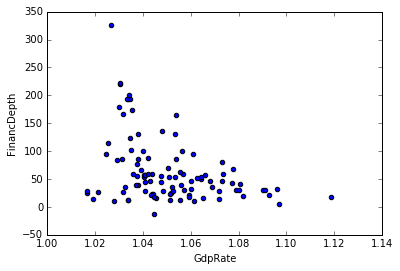

In [25]:
finalSample.plot.scatter("GdpRate","FinancDepth")